# Time Series Analytics on Tweet Cluster

# Fetch Cluster Data

In [1]:
#importing libraries
import json
import pandas as pd

In [2]:
tweet_frequency = json.loads(open('../result/tweet_cluster_frequency.json').read())
hash_cluster = json.loads(open('../result/hash_cluster.json').read())

In [3]:
tweet_frequency

{'0': {'2016-10-1': 52,
  '2016-10-10': 26,
  '2016-10-11': 118,
  '2016-10-12': 10,
  '2016-10-13': 132,
  '2016-10-14': 88,
  '2016-10-15': 26,
  '2016-10-16': 14,
  '2016-10-17': 10,
  '2016-10-18': 50,
  '2016-10-19': 34,
  '2016-10-2': 4,
  '2016-10-20': 36,
  '2016-10-21': 20,
  '2016-10-22': 36,
  '2016-10-23': 2,
  '2016-10-24': 2,
  '2016-10-25': 6,
  '2016-10-26': 6,
  '2016-10-27': 14,
  '2016-10-28': 106,
  '2016-10-29': 48,
  '2016-10-3': 10,
  '2016-10-30': 6,
  '2016-10-31': 142,
  '2016-10-4': 80,
  '2016-10-5': 14,
  '2016-10-6': 64,
  '2016-10-7': 70,
  '2016-10-8': 76,
  '2016-10-9': 20,
  '2016-11-1': 56,
  '2016-11-10': 142,
  '2016-11-11': 60,
  '2016-11-12': 40,
  '2016-11-14': 4,
  '2016-11-15': 74,
  '2016-11-16': 98,
  '2016-11-17': 90,
  '2016-11-18': 32,
  '2016-11-19': 152,
  '2016-11-2': 68,
  '2016-11-20': 6,
  '2016-11-22': 68,
  '2016-11-23': 30,
  '2016-11-24': 70,
  '2016-11-25': 170,
  '2016-11-26': 6,
  '2016-11-27': 14,
  '2016-11-28': 80,
  '2016-

In [4]:
hash_cluster

{'0': ['security',
  'Remote',
  'OpenSSH',
  'Safari',
  'malware',
  'in',
  'Struts',
  'TA459'],
 '1': ['McAfee',
  'ManicSec',
  'itsec',
  'cybersec',
  'SecAlert',
  'CVE',
  'ITSec',
  'Financial',
  'open',
  'netbackup',
  'junos'],
 '10': ['vulnarchive',
  'rootsector',
  'virus',
  'ransomware',
  'Root',
  'ZeroDay',
  '0Day',
  'kernel',
  'CyberNews',
  'Wireshark',
  'Mozilla',
  'infoSec',
  'threatintel',
  'spam',
  'Disclosure',
  'Fortinet',
  'firefox',
  'i',
  'PowerPoint',
  'DoS',
  'printer',
  'C',
  'Kernel',
  'vulnerabilitydatabase',
  'Moxa',
  'WordPress',
  'iSecDotNews',
  'securi',
  'ACE',
  'MySQL',
  'zeroda',
  'cve',
  'secu',
  'Metasploit',
  'cloudcomputing',
  'Phishing',
  'ESA',
  'Denial',
  'Bypass',
  'cyb',
  'Tomcat',
  'privilege',
  'securityaffa',
  'ai',
  'DirtyCow',
  'securitya',
  'DLink',
  'SCADA',
  'PatchTuesday',
  'tech',
  'DDoS',
  'wireshark',
  'system',
  'fedora',
  'CloudLinux',
  'solaris',
  'PHPMailer',
  'PHPM

In [5]:
def pick_cluster(cluster_id):
    dataframe = pd.DataFrame.from_dict(tweet_frequency[cluster_id], orient='index')
    dataframe = dataframe.rename(index=str, columns={0:'count'})
    hashtags = hash_cluster[cluster_id]
    
    dataframe.index = pd.to_datetime(dataframe.index, format='%Y-%m-%d')
    timeseries = pd.Series(dataframe['count'], index=dataframe.index).sort_index()
        
    timeseries = timeseries.to_frame()
    timeseries = timeseries.resample('D').sum().fillna(0)
    
    return hashtags, timeseries

In [6]:
hashtags, timeseries = pick_cluster('15')
print(type(timeseries))
print(hashtags)
print(timeseries.head())

<class 'pandas.core.frame.DataFrame'>
['cybersecurity', 'java', 'Vulnerability', 'sec', 'spartan', 'MeetingSe', 'iot', 'gstreamer', 'Hacked', 'virusscan', 'WannaCry']
            count
2016-03-09      8
2016-03-10      8
2016-03-11      0
2016-03-12      0
2016-03-13      0


In [7]:
width = 18
height = 7
try:
    fig = plt.figure(figsize=(width, height)) 
    plt.plot(timeseries, color='blue') 
    plt.show()
except Exception as e:
    print(str(e))

name 'plt' is not defined


# Time Series Analysis - MLP 

In [8]:
#importing libraries
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D

%matplotlib inline  

Using TensorFlow backend.


In [9]:
def split_into_chunks(data, train, predict, step, binary=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                
            else:
                timeseries = np.array(data[i:i+train+predict])
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y


def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.7):
    partition = int(len(X) * percentage)
    X_train = X[0:partition]
    Y_train = y[0:partition]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[partition:]
    Y_test = y[partition:]

    return X_train, X_test, Y_train , Y_test

In [109]:
TRAIN_SIZE = 30
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

hashtags, timeseries = pick_cluster('19')
print(hashtags)

X, Y = split_into_chunks(timeseries['count'], TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.8)

['IoT', 'Bugs', 'Security', 'vulnerability', 'Exploit', 'pentest', 'Android', 'CyberSecurity', 'Intel', 'svchost']


In [110]:
#model creation - Multilayer Perceptron

#Initialize our MLP 
model = Sequential()

#First layer Input: Train data, Output: 512 units, with RELU Activation Function and using Droupout of 25 %
model.add(Dense(512, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Second layer Input: Previous layer, Output: 64 units, with RELU Activation Function
model.add(Dense(64))
model.add(Activation('relu'))

#Final Layer with Input: Previous Layer, Output: 1 Units
model.add(Dense(1))
model.add(Activation('linear'))

#Assign optimizer as ADAM and loss function to be Mean Squared Error
model.compile(optimizer='adam', loss='mse')

#Training the model on 1000 epochs with batch size = 16
model.fit(X_train, Y_train, nb_epoch=1000, batch_size = 16, verbose=1, validation_split=0.1)

#Evaluating the loss function
score = model.evaluate(X_test, Y_test, batch_size=16)
print(score)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 367 samples, validate on 41 samples
Epoch 1/1000
367/367 [==============================] - 1s 2ms/step - loss: 1165.2900 - val_loss: 1545.2576
Epoch 2/1000
367/367 [==============================] - 0s 80us/step - loss: 766.8606 - val_loss: 1787.4358
Epoch 3/1000
367/367 [==============================] - 0s 77us/step - loss: 611.2501 - val_loss: 1685.2350
Epoch 4/1000
367/367 [==============================] - 0s 79us/step - loss: 515.6500 - val_loss: 1873.0758
Epoch 5/1000
367/367 [==============================] - 0s 83us/step - loss: 459.1732 - val_loss: 1762.5887
Epoch 6/1000
367/367 [==============================] - 0s 85us/step - loss: 440.5959 - val_loss: 1985.9138
Epoch 7/1000
367/367 [==============================] - 0s 91us/step - loss: 412.4753 - val_loss: 2038.3375
Epoch 8/1000
367/367 [==============================] - 0s 92us/step - loss: 364.7673 - val_loss: 1948.5209
Epoch 9/1000
367/367 [==============================] - 0s 92us/step - loss: 336.7045 - val

Epoch 76/1000
367/367 [==============================] - 0s 78us/step - loss: 69.3276 - val_loss: 1850.6855
Epoch 77/1000
367/367 [==============================] - 0s 79us/step - loss: 94.4473 - val_loss: 2046.1016
Epoch 78/1000
367/367 [==============================] - 0s 80us/step - loss: 118.2035 - val_loss: 2196.9147
Epoch 79/1000
367/367 [==============================] - 0s 80us/step - loss: 71.1686 - val_loss: 1982.7155
Epoch 80/1000
367/367 [==============================] - 0s 79us/step - loss: 56.3631 - val_loss: 2256.0267
Epoch 81/1000
367/367 [==============================] - 0s 80us/step - loss: 69.9396 - val_loss: 2047.7678
Epoch 82/1000
367/367 [==============================] - 0s 81us/step - loss: 93.8294 - val_loss: 2059.6270
Epoch 83/1000
367/367 [==============================] - 0s 79us/step - loss: 97.7376 - val_loss: 2173.8172
Epoch 84/1000
367/367 [==============================] - 0s 81us/step - loss: 72.7012 - val_loss: 1967.5021
Epoch 85/1000
367/367 [====

367/367 [==============================] - 0s 76us/step - loss: 29.1643 - val_loss: 1876.4271
Epoch 227/1000
367/367 [==============================] - 0s 74us/step - loss: 34.6171 - val_loss: 1983.1383
Epoch 228/1000
367/367 [==============================] - 0s 78us/step - loss: 31.4448 - val_loss: 2270.4061
Epoch 229/1000
367/367 [==============================] - 0s 75us/step - loss: 27.0377 - val_loss: 1928.3238
Epoch 230/1000
367/367 [==============================] - 0s 77us/step - loss: 28.0423 - val_loss: 2050.4260
Epoch 231/1000
367/367 [==============================] - 0s 77us/step - loss: 17.0801 - val_loss: 2108.3159
Epoch 232/1000
367/367 [==============================] - 0s 78us/step - loss: 15.8177 - val_loss: 2010.0268
Epoch 233/1000
367/367 [==============================] - 0s 80us/step - loss: 20.3131 - val_loss: 2230.1947
Epoch 234/1000
367/367 [==============================] - 0s 79us/step - loss: 18.1972 - val_loss: 1986.3876
Epoch 235/1000
367/367 [==========

367/367 [==============================] - 0s 81us/step - loss: 11.2022 - val_loss: 1975.9900
Epoch 377/1000
367/367 [==============================] - 0s 81us/step - loss: 14.6930 - val_loss: 2085.0946
Epoch 378/1000
367/367 [==============================] - 0s 76us/step - loss: 18.6069 - val_loss: 1924.6039
Epoch 379/1000
367/367 [==============================] - 0s 76us/step - loss: 16.5813 - val_loss: 1823.6515
Epoch 380/1000
367/367 [==============================] - 0s 78us/step - loss: 19.1621 - val_loss: 1901.9355
Epoch 381/1000
367/367 [==============================] - 0s 79us/step - loss: 18.4003 - val_loss: 2008.0762
Epoch 382/1000
367/367 [==============================] - 0s 76us/step - loss: 24.2693 - val_loss: 1843.9204
Epoch 383/1000
367/367 [==============================] - 0s 77us/step - loss: 16.0783 - val_loss: 1775.5814
Epoch 384/1000
367/367 [==============================] - 0s 77us/step - loss: 19.9736 - val_loss: 1714.1732
Epoch 385/1000
367/367 [==========

367/367 [==============================] - 0s 86us/step - loss: 19.0277 - val_loss: 1698.5496
Epoch 527/1000
367/367 [==============================] - 0s 79us/step - loss: 20.0866 - val_loss: 2016.2461
Epoch 528/1000
367/367 [==============================] - 0s 82us/step - loss: 19.8482 - val_loss: 1905.1355
Epoch 529/1000
367/367 [==============================] - 0s 92us/step - loss: 18.3777 - val_loss: 1721.0843
Epoch 530/1000
367/367 [==============================] - 0s 79us/step - loss: 18.3655 - val_loss: 1853.8062
Epoch 531/1000
367/367 [==============================] - 0s 80us/step - loss: 22.6263 - val_loss: 1849.9585
Epoch 532/1000
367/367 [==============================] - 0s 76us/step - loss: 20.5159 - val_loss: 1877.8726
Epoch 533/1000
367/367 [==============================] - 0s 85us/step - loss: 15.7258 - val_loss: 1779.4443
Epoch 534/1000
367/367 [==============================] - 0s 82us/step - loss: 13.9297 - val_loss: 1920.4834
Epoch 535/1000
367/367 [==========

367/367 [==============================] - 0s 76us/step - loss: 19.4114 - val_loss: 1864.0067
Epoch 677/1000
367/367 [==============================] - 0s 78us/step - loss: 21.1321 - val_loss: 1895.4581
Epoch 678/1000
367/367 [==============================] - 0s 77us/step - loss: 11.7281 - val_loss: 1866.9773
Epoch 679/1000
367/367 [==============================] - 0s 77us/step - loss: 10.7886 - val_loss: 1926.3780
Epoch 680/1000
367/367 [==============================] - 0s 78us/step - loss: 13.5895 - val_loss: 1832.4363
Epoch 681/1000
367/367 [==============================] - 0s 74us/step - loss: 24.9453 - val_loss: 1826.7853
Epoch 682/1000
367/367 [==============================] - 0s 81us/step - loss: 21.3914 - val_loss: 1977.8587
Epoch 683/1000
367/367 [==============================] - 0s 77us/step - loss: 11.4805 - val_loss: 1779.9526
Epoch 684/1000
367/367 [==============================] - 0s 75us/step - loss: 12.0371 - val_loss: 1823.3919
Epoch 685/1000
367/367 [==========

367/367 [==============================] - 0s 82us/step - loss: 11.4853 - val_loss: 1848.7125
Epoch 827/1000
367/367 [==============================] - 0s 81us/step - loss: 8.8876 - val_loss: 1870.0927
Epoch 828/1000
367/367 [==============================] - 0s 82us/step - loss: 10.7818 - val_loss: 1824.7023
Epoch 829/1000
367/367 [==============================] - 0s 77us/step - loss: 12.4408 - val_loss: 1883.4444
Epoch 830/1000
367/367 [==============================] - 0s 80us/step - loss: 16.2342 - val_loss: 1741.2491
Epoch 831/1000
367/367 [==============================] - 0s 80us/step - loss: 9.6277 - val_loss: 1780.3573
Epoch 832/1000
367/367 [==============================] - 0s 80us/step - loss: 11.9156 - val_loss: 1799.3151
Epoch 833/1000
367/367 [==============================] - 0s 79us/step - loss: 12.0188 - val_loss: 1930.5472
Epoch 834/1000
367/367 [==============================] - 0s 79us/step - loss: 14.7267 - val_loss: 1786.4860
Epoch 835/1000
367/367 [============

367/367 [==============================] - 0s 75us/step - loss: 27.0140 - val_loss: 1837.7713
Epoch 977/1000
367/367 [==============================] - 0s 80us/step - loss: 15.5746 - val_loss: 1897.6247
Epoch 978/1000
367/367 [==============================] - 0s 78us/step - loss: 14.2526 - val_loss: 1733.1740
Epoch 979/1000
367/367 [==============================] - 0s 78us/step - loss: 13.0079 - val_loss: 1850.3222
Epoch 980/1000
367/367 [==============================] - 0s 79us/step - loss: 8.4844 - val_loss: 1861.8358
Epoch 981/1000
367/367 [==============================] - 0s 77us/step - loss: 14.0778 - val_loss: 1863.9535
Epoch 982/1000
367/367 [==============================] - 0s 80us/step - loss: 18.0154 - val_loss: 1934.6722
Epoch 983/1000
367/367 [==============================] - 0s 77us/step - loss: 22.4711 - val_loss: 1590.5070
Epoch 984/1000
367/367 [==============================] - 0s 83us/step - loss: 20.4083 - val_loss: 1839.4142
Epoch 985/1000
367/367 [===========

In [111]:
score = int(score)

#Total mean squared error
print('Total Mean Squared Error: '+str(score))

#Squared error on per day basis
print('Average error per day: '+str(score/len(X_test)))

Total Mean Squared Error: 550
Average error per day: 5.392156862745098


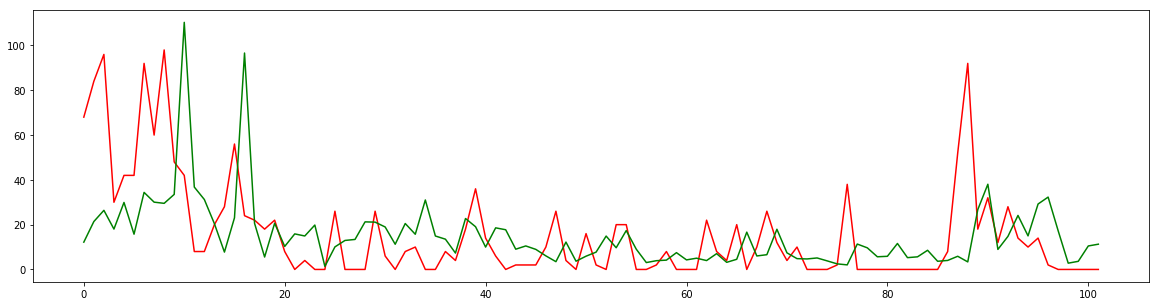

In [112]:
#model prediction : Test data
predicted = model.predict(X_test)
width = 20
height = 5

try:
    fig = plt.figure(figsize=(width, height))
    plt.plot(Y_test, color='red') 
    plt.plot(predicted, color='green') 
    plt.show()
except Exception as e:
    print(str(e))

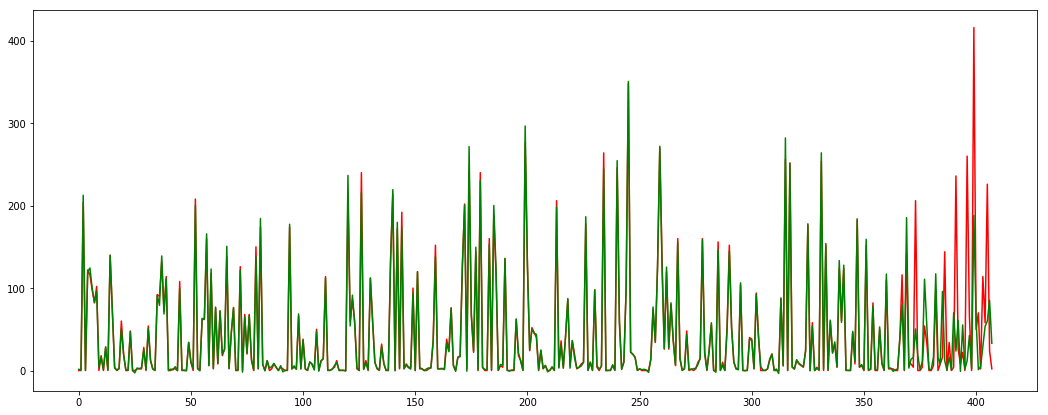

In [99]:
#model prediction : Train data
predicted = model.predict(X_train)
width = 18
height = 7

try:
    fig = plt.figure(figsize=(width, height))
    plt.plot(Y_train, color='red') 
    plt.plot(predicted, color='green') 
    plt.show()
except Exception as e:
    print(str(e))

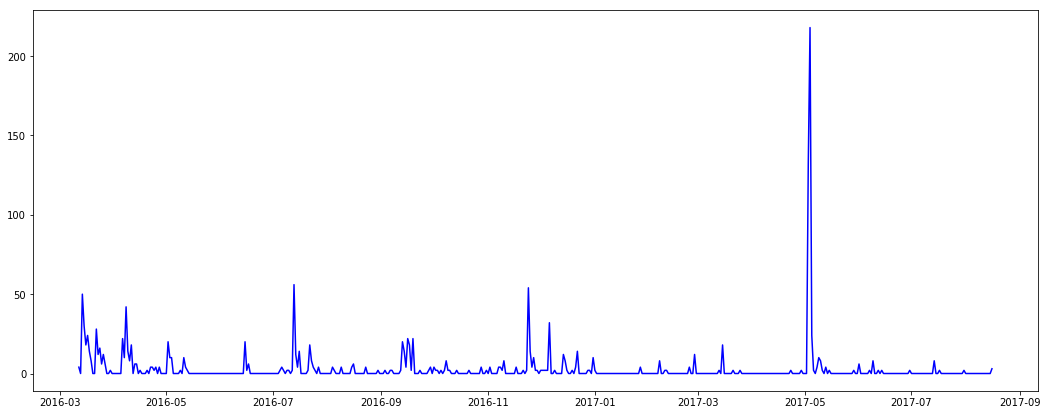

In [93]:
width = 18
height = 7

try:
    fig = plt.figure(figsize=(width, height))
    plt.plot(timeseries, color='blue') 
    plt.show()
except Exception as e:
    print(str(e))